In [278]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data_gnn, train, get_batch_dimensions, energies_and_forces_model
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
import mdtraj as m
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import mean_squared_error

In [252]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

### Load MD data

In [254]:
positions = torch.load('positions.pt')
potential_energies = torch.load('e_pot.pt')
forces = torch.load('forces.pt')

n_samples = potential_energies.shape[0]
positions.shape, potential_energies.shape

(torch.Size([10000, 4, 3]), torch.Size([10000, 1]))

In [255]:
n_particles = positions.shape[-2]

In [256]:
atomic_numbers = torch.ones(( n_samples, n_particles,1))

In [257]:
all_data,train_data,test_data = split_data_gnn(positions, potential_energies,forces,atomic_numbers, train_fraction=.9, device=DEVICE)


Note that we reshaped the positions from (n_samples, n_particles, 3) to (n_samples*n_particles, 3)   because the PyTorch Geometric library expects it this way.

In [258]:
train_data.positions.shape

torch.Size([9000, 4, 3])

## Model

Load your own model if you have implemented one in Exercise 10!

In [259]:
from schnet_solution import SchNet

In [260]:
net = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

This is how we get energy predictions from the model for a batch of samples.

In [261]:
n_samples = 10
batch_dimensions = get_batch_dimensions(n_samples, n_particles)

In [262]:
predictions = net(
    train_data.atomic_numbers[:n_samples].reshape(-1, 1),
    train_data.positions[:n_samples].reshape(-1, 3),
    batch_dimensions,
)
predictions

tensor([[-1.2655],
        [-1.2652],
        [-1.2650],
        [-1.2611],
        [-1.2645],
        [-1.2601],
        [-1.2655],
        [-1.2647],
        [-1.2632],
        [-1.2650]], grad_fn=<ScatterAddBackward0>)

In [263]:
trainloader = DataLoader(train_data,batch_size=64,shuffle=True)
testloader = DataLoader(test_data,batch_size=64,shuffle=True)

In [264]:
# criterion to computes the loss between input and target
criterion = nn.MSELoss()

# optimizer that will be used to update weights and biases
my_optim = torch.optim.Adam(net.parameters(),lr=1e-3)

In [265]:
# Assume SchNet, train function, and dataset loaders are already defined
hidden_channels = 32
num_filters = 32
num_interactions = 2
num_gaussians = 10
cutoff = 10.0
lr1 = 1e-3
lr2 = 1e-4
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Number of epochs
NUM_EPOCHS = 200

energy_train_losses = []
energy_test_losses = []
force_train_losses = []
force_test_losses = []

# Define models
energy_model = SchNet(hidden_channels, num_filters, num_interactions, num_gaussians, cutoff).to(device)
force_model = SchNet(hidden_channels, num_filters, num_interactions, num_gaussians, cutoff).to(device)

energy_optimizer = optim.Adam(energy_model.parameters(), lr=lr1)
force_optimizer = optim.Adam(force_model.parameters(), lr=lr1)

energy_scheduler = LambdaLR(energy_optimizer, lr_lambda=lambda epoch: 0.1 if epoch >= epochs else 1.0)
force_scheduler = LambdaLR(force_optimizer, lr_lambda=lambda epoch: 0.1 if epoch >= epochs else 1.0)


In [266]:
# # Train Energy-Only Model
# print("Training Energy-Only Model...")
# train(
#     model=energy_model,
#     train_loader=trainloader,
#     optimizer=energy_optimizer,
#     criterion=torch.nn.MSELoss(),
#     rho_ene=1.0,
#     rho_force=0.0,
#     device=device,
#     scheduler=energy_scheduler,
# )

# # Train Force-Only Model
# print("Training Force-Only Model...")
# train(
#     model=force_model,
#     train_loader=testloader,
#     optimizer=force_optimizer,
#     criterion=torch.nn.MSELoss(),
#     rho_ene=0.0,
#     rho_force=1.0,
#     device=device,
#     scheduler=force_scheduler,
# )

In [267]:
def test(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    rho_ene: float,
    rho_force: float,
    device,
):
    """
    Evaluate the model on a test dataset.

    Parameters:
    -----------
    model : pytorch model.
    test_loader : pytorch Dataloader containing the test data.
    criterion: Loss function.
    rho_ene: Weight for energy loss.
    rho_force: Weight for force loss.
    device: Device (CPU or GPU).

    Returns:
    --------
    Average test loss across all batches.
    """
    # model.eval()  # Set model to evaluation mode
    model.train()
    epoch_loss = 0
    n_batches = len(test_loader)

    for positions, energies, forces, z in test_loader:
        # Copy data to device
        positions = positions.to(device)
        z = z.to(device)
        energies = energies.to(device)
        forces = forces.to(device)

        n_particles = positions.shape[-2]

        # Ensure positions tensor has requires_grad=True for force calculation
        positions = positions.clone().requires_grad_(True)  # Make sure requires_grad is set here

        # Forward pass (without tracking gradients for the model parameters)
        # with torch.no_grad():  # Disable gradients for the model parameters
        model_energies, model_forces = energies_and_forces_model(model, positions, z)

        # Now calculate losses using the energy and forces predictions
        loss_forces = (1 / n_particles) * torch.sum((forces - model_forces) ** 2)
        loss_energies = torch.sum((model_energies - energies) ** 2)

        # Total loss
        loss = rho_ene * loss_energies + rho_force * loss_forces
        epoch_loss += loss.item()

    return epoch_loss / n_batches






In [ ]:

# Training loop
for epoch in range(NUM_EPOCHS):
        # Train energy model (energy-only training)
    energy_train_loss = train(energy_model, trainloader, energy_optimizer, criterion, rho_ene=1, rho_force=0, device=device)
    energy_train_losses.append(energy_train_loss)
    
    # Train force model (force-only training)
    force_train_loss = train(force_model, trainloader, force_optimizer, criterion, rho_ene=0, rho_force=1, device=device)
    force_train_losses.append(force_train_loss)


    # Evaluate and store the test loss (if needed)
    energy_test_loss = test(energy_model, testloader, criterion, rho_ene=1, rho_force=0, device=device)  # Energy test
    energy_test_losses.append(energy_test_loss)
    
    force_test_loss = test(force_model, testloader, criterion, rho_ene=0, rho_force=1, device=device)  # Force test
    force_test_losses.append(force_test_loss)

    # Print epoch results
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")
    print(f" Energy Model - Test Loss: {energy_test_loss:.4f}, Train Loss: {energy_train_loss:.4f}")
    print(f"  Force Model - Test Loss: {force_test_loss:.4f}, Train Loss: {force_train_loss:.4f}")

    # Update the learning rate based on the scheduler
    energy_scheduler.step()
    force_scheduler.step()

    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} completed.")

Epoch: 1/200
 Energy Model - Test Loss: 0.8981, Train Loss: 0.8755, Test Loss: 0.8981
  Force Model - Test Loss: 72.1882, Train Loss: 48.5589, Test Loss: 72.1882
Epoch 1/200 completed.
Epoch: 2/200
 Energy Model - Test Loss: 1.1818, Train Loss: 0.8755, Test Loss: 1.1818
  Force Model - Test Loss: 63.0363, Train Loss: 48.5589, Test Loss: 63.0363
Epoch 2/200 completed.
Epoch: 3/200
 Energy Model - Test Loss: 1.0001, Train Loss: 0.8755, Test Loss: 1.0001
  Force Model - Test Loss: 56.8525, Train Loss: 48.5589, Test Loss: 56.8525
Epoch 3/200 completed.
Epoch: 4/200
 Energy Model - Test Loss: 0.8613, Train Loss: 0.8755, Test Loss: 0.8613
  Force Model - Test Loss: 47.5408, Train Loss: 48.5589, Test Loss: 47.5408
Epoch 4/200 completed.
Epoch: 5/200
 Energy Model - Test Loss: 0.9190, Train Loss: 0.8755, Test Loss: 0.9190
  Force Model - Test Loss: 67.3113, Train Loss: 48.5589, Test Loss: 67.3113
Epoch 5/200 completed.
Epoch: 6/200
 Energy Model - Test Loss: 1.0915, Train Loss: 0.8755, Test Lo

In [272]:
# Save the energy model
torch.save(energy_model.state_dict(), 'energy_model.pth')
print("Energy model saved!")

# Save the force model
torch.save(force_model.state_dict(), 'force_model.pth')
print("Force model saved!")

Energy model saved!
Force model saved!


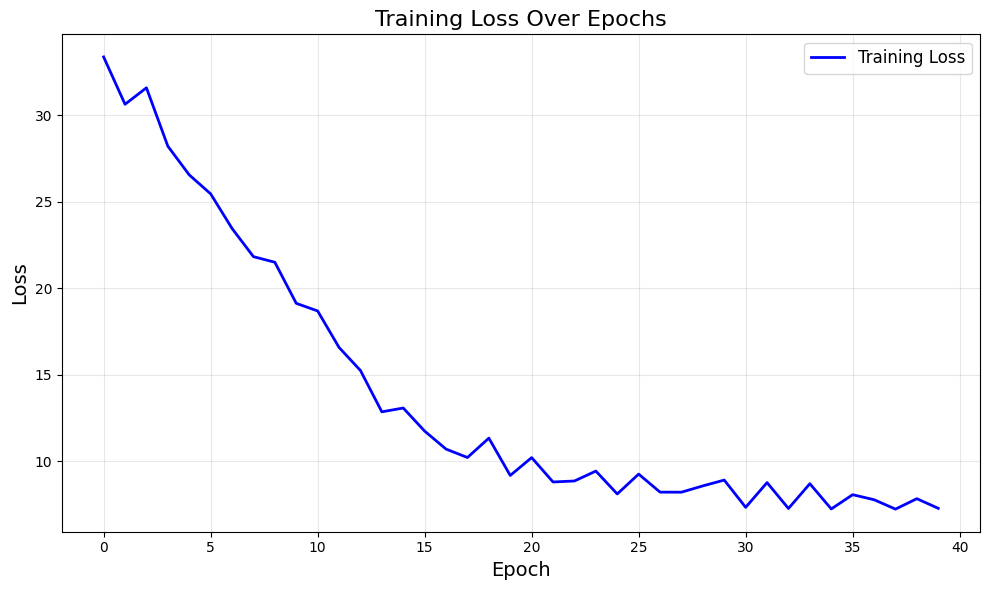

In [ ]:
# # Create a plot
# plt.figure(figsize=(10, 6))
# plt.plot(losses, label='Training Loss', color='blue', linewidth=2)
# plt.title('Training Loss Over Epochs', fontsize=16)
# plt.xlabel('Epoch', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.grid(alpha=0.3)
# plt.legend(fontsize=12)
# plt.tight_layout()

# # Show the plot
# plt.show()

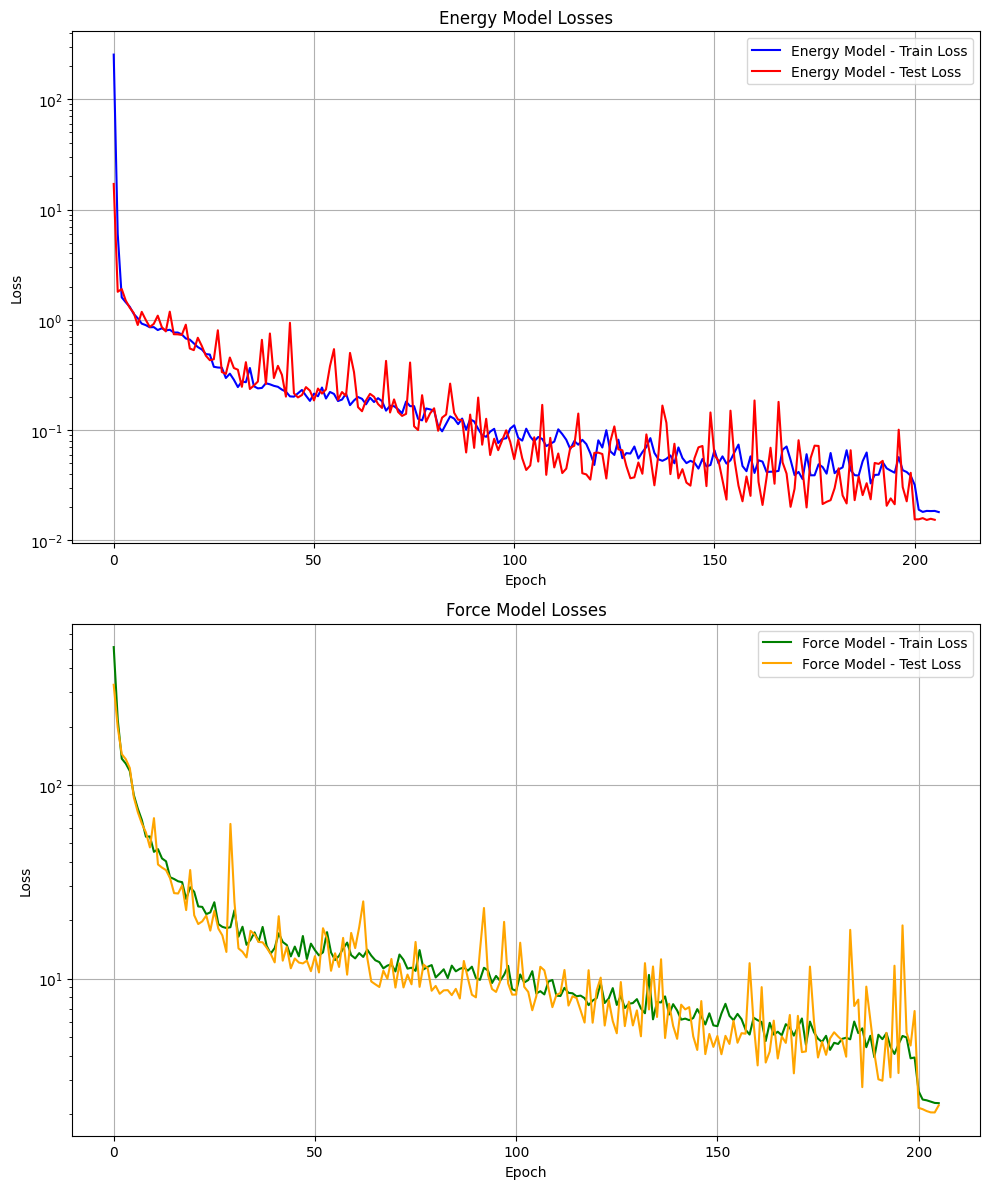

In [276]:

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Energy model losses (Plot on the first subplot)
ax1.plot(energy_train_losses, label='Energy Model - Train Loss', color='blue')
ax1.plot(energy_test_losses, label='Energy Model - Test Loss', color='red')
ax1.set_title('Energy Model Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True)

# Force model losses (Plot on the second subplot)
ax2.plot(force_train_losses, label='Force Model - Train Loss', color='green')
ax2.plot(force_test_losses, label='Force Model - Test Loss', color='orange')
ax2.set_title('Force Model Losses')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [293]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    device,
):
    """
    Get the predicted and true values for energies and forces on a test dataset.

    Parameters:
    -----------
    model : pytorch model.
    test_loader : pytorch Dataloader containing the test data.
    device: Device (CPU or GPU).

    Returns:
    --------
    true_energies, predicted_energies, true_forces, predicted_forces
    """
    model.train()  # Set model to evaluation mode
    true_energies = []
    predicted_energies = []
    true_forces = []
    predicted_forces = []

    # with torch.no_grad():  # Disable gradient computation
    for positions, energies, forces, z in test_loader:
        # Copy data to device
        positions = positions.to(device)
        z = z.to(device)
        energies = energies.to(device)
        forces = forces.to(device)

        # Ensure positions tensor has requires_grad=True for force calculation
        positions = positions.clone().requires_grad_(True)

        # Forward pass: Get predicted energies and forces
        model_energies, model_forces = energies_and_forces_model(model, positions, z)

        # Store true and predicted values
        true_energies.append(energies.cpu().numpy())
        predicted_energies.append(model_energies.cpu().detach().numpy())
        true_forces.append(forces.cpu().numpy())
        predicted_forces.append(model_forces.cpu().detach().numpy())

    # Flatten the lists
    true_energies = np.concatenate(true_energies, axis=0)
    predicted_energies = np.concatenate(predicted_energies, axis=0)
    true_forces = np.concatenate(true_forces, axis=0)
    predicted_forces = np.concatenate(predicted_forces, axis=0)

    return true_energies, predicted_energies, true_forces, predicted_forces

true_energies, predicted_energies, true_forces, predicted_forces = evaluate_model(energy_model, testloader, device)


(1000, 4, 3) (1000, 4, 3)
Mean Squared Error for Energies: 0.0002
Mean Squared Error for Forces: 0.1065


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

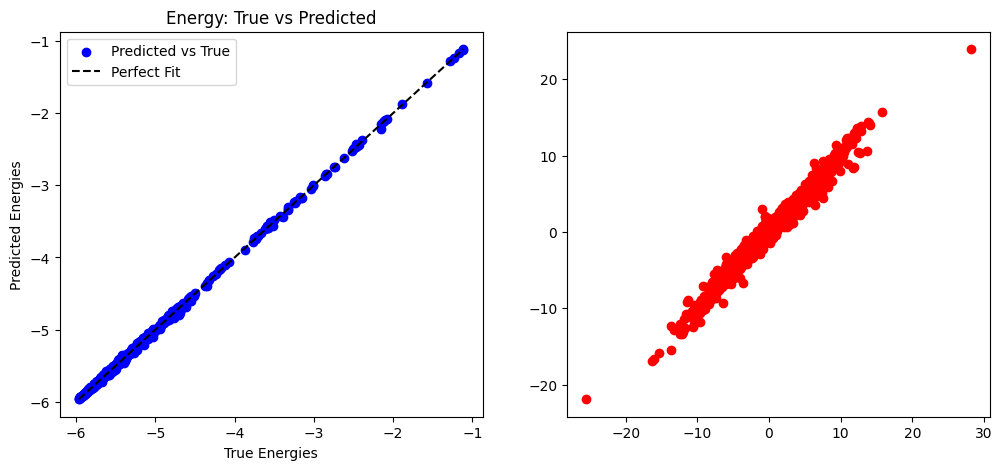

In [ ]:
print(true_forces.shape, predicted_forces.shape)

# Calculate MSE for energies and forces
mse_energies = mean_squared_error(true_energies, predicted_energies)

true_forces_flat = true_forces.reshape(-1, 3)  # Flatten to (N, 3)
predicted_forces_flat = predicted_forces.reshape(-1, 3)  # Flatten to (N, 3)
    
mse_3d_forces = mean_squared_error(true_forces_flat, predicted_forces_flat)


print(f"Mean Squared Error for Energies: {mse_energies:.4f}")
print(f"Mean Squared Error for Forces: {mse_3d_forces:.4f}")

# Plot true vs predicted values for Energies
plt.figure(figsize=(12, 5))

# Energy plot
plt.subplot(1, 2, 1)
plt.scatter(true_energies, predicted_energies, color='blue', label='Predicted vs True')
plt.plot([min(true_energies), max(true_energies)], [min(true_energies), max(true_energies)], 'k--', label='Perfect Fit')
plt.title('Energy: True vs Predicted')
plt.xlabel('True Energies')
plt.ylabel('Predicted Energies')
plt.legend()

# Force plot
plt.subplot(1, 2, 2)
plt.scatter(true_forces, predicted_forces, color='red', label='Predicted vs True')
# plt.plot([min(true_forces_flat), max(true_forces_flat)], [min(true_forces_flat), max(true_forces_flat)], 'k--', label='Perfect Fit')
plt.title('Force: True vs Predicted')
plt.xlabel('True Forces')
plt.ylabel('Predicted Forces')
plt.legend()

plt.tight_layout()
plt.show()

